# Introduction

In this section, we will use the spectrograms made in the EDA notebook to train CNN models and we will present different models including transfer learning.

# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

GPU is available


In [3]:
!nvidia-smi

Wed Aug 10 22:08:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Functions

The function `loss_acc` is defined to take the model and returns the loss and accuracy diagrams of the model.

In [4]:
def loss_acc(model):


    fig , ax = plt.subplots(1,2)


    test_acc = model.history.history["val_accuracy"]
    test_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    train_loss = model.history.history["loss"]

    epochs = range(1, len(test_acc) + 1)

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()


In [108]:
def extract_features(directory, sample_amount, transfer, out_size, batch_size, n_class):
    features = np.zeros(shape=(sample_amount, out_size)) 
    labels = np.zeros(shape=(sample_amount, n_class))
    generator = datagen.flow_from_directory(
                                            directory, 
                                            target_size = target_size, 
                                            batch_size  = batch_size, 
                                            class_mode  ='categorical')
    # i=0
    for i, (inputs_batch, labels_batch) in enumerate(generator):
        features_batch = transfer.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

# Importing Train-Test data sets

In [7]:
base_dir = "/content/drive/MyDrive/Classification-of-Heart-Sound-Signal-Using-Multiple-Features-/spectrograms"

train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Directory with training normal/abnormal spectrograms
train_AS  = os.path.join(train_dir, 'AS')
train_MR  = os.path.join(train_dir, 'MR')
train_MS  = os.path.join(train_dir, 'MS')
train_MVP = os.path.join(train_dir, 'MVP')
train_N   = os.path.join(train_dir, 'N')



# Directory with test normal/abnormal spectrograms

test_AS  = os.path.join(test_dir, 'AS')
test_MR  = os.path.join(test_dir, 'MR')
test_MS  = os.path.join(test_dir, 'MS')
test_MVP = os.path.join(test_dir, 'MVP')
test_N   = os.path.join(test_dir, 'N')


In [97]:
# All images will be rescaled by 1./255.

batch_size = 5

train_datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
test_datagen  = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)

target_size = (150, 150)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    shuffle = False,
                                                    target_size=target_size)     

validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=batch_size,
                                                         class_mode  = "categorical",
                                                         shuffle = False,
                                                         target_size = target_size)

Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


# Modeling

In this section, we will present some CNN based models and we will use some transfer learning models to be used in this work.

## Convolutional Neural Network

In this section, we will present the CNN based models.

### First Model

In [98]:
model_1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(5, activation='softmax')  
])
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 175232)            0         
                                                                 
 dense_8 (Dense)             (None, 64)                11214912  
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 11,216,133
Trainable params: 11,216,133
Non-trainable params: 0
__________________________________________

In [99]:
model_1.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics = ['accuracy'])


model_1.fit_generator(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
           )
print("Fitting Done")

Epoch 1/15
160/160 [==============================] - 38s 228ms/step - loss: 1.0430 - accuracy: 0.7150 - val_loss: 0.5612 - val_accuracy: 0.7900
Epoch 2/15
160/160 [==============================] - 35s 217ms/step - loss: 0.4079 - accuracy: 0.8813 - val_loss: 0.2744 - val_accuracy: 0.9000
Epoch 3/15
160/160 [==============================] - 35s 221ms/step - loss: 0.1703 - accuracy: 0.9550 - val_loss: 0.2399 - val_accuracy: 0.9100
Epoch 4/15
160/160 [==============================] - 39s 241ms/step - loss: 0.0735 - accuracy: 0.9800 - val_loss: 0.1635 - val_accuracy: 0.9400
Epoch 5/15
160/160 [==============================] - 36s 227ms/step - loss: 0.0641 - accuracy: 0.9775 - val_loss: 0.1910 - val_accuracy: 0.9300
Epoch 6/15
160/160 [==============================] - 38s 236ms/step - loss: 0.0164 - accuracy: 0.9950 - val_loss: 0.1696 - val_accuracy: 0.9450
Epoch 7/15
160/160 [==============================] - 34s 212ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1353 - val_ac

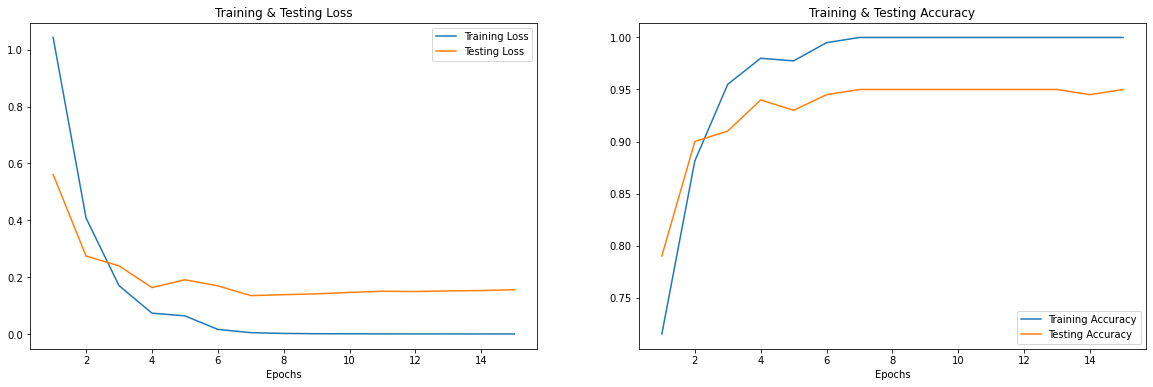

In [100]:
loss_acc(model_1)

              precision    recall  f1-score   support

          AS       0.95      0.97      0.96        40
          MR       0.95      0.88      0.91        40
          MS       0.95      0.97      0.96        40
         MVP       0.93      0.95      0.94        40
           N       0.97      0.97      0.97        40

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



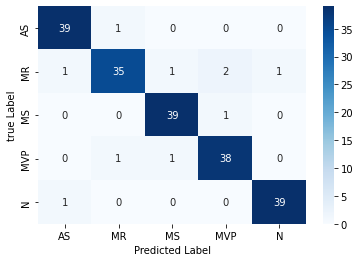

In [138]:
pred = model_1.predict_generator(validation_generator)
predicted_class = np.argmax(pred, axis = 1)
labels = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, predicted_class, 
                            target_names=labels))

cf_matrix_test  = confusion_matrix(validation_generator.classes, 
                                   predicted_class)


g = sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')

g.xaxis.set_ticklabels(labels)
g.yaxis.set_ticklabels(labels)

g.set_xlabel('Predicted Label', fontsize=10)
g.set_ylabel('true Label', fontsize=10);


## Transfer Learning

In this section, we will use transfer learning models `EfficientNetB3` and `EfficientNetB7` to train a neural network.

## `EfficientNetB1`


This worked well and put the results in the proposal.

In [110]:
# All images will be rescaled by 1./255.
datagen = ImageDataGenerator( rescale = 1.0/255, dtype= tf.float64)
batch_size = 10
target_size = (150, 150)
input_shape = (target_size[0], target_size[1], 3)



model_name='EfficientNetB1'

efficient_1=tf.keras.applications.EfficientNetB1(
                                      include_top=False, 
                                      weights="imagenet",
                                      input_shape=input_shape,
                                      classes=5,
                                      classifier_activation='softmax',
                                      pooling='max') 

# efficient_1.summary()

27033600/27018416 [==============================] - 0s 0us/step


Found 800 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
DONE
Fitting Done


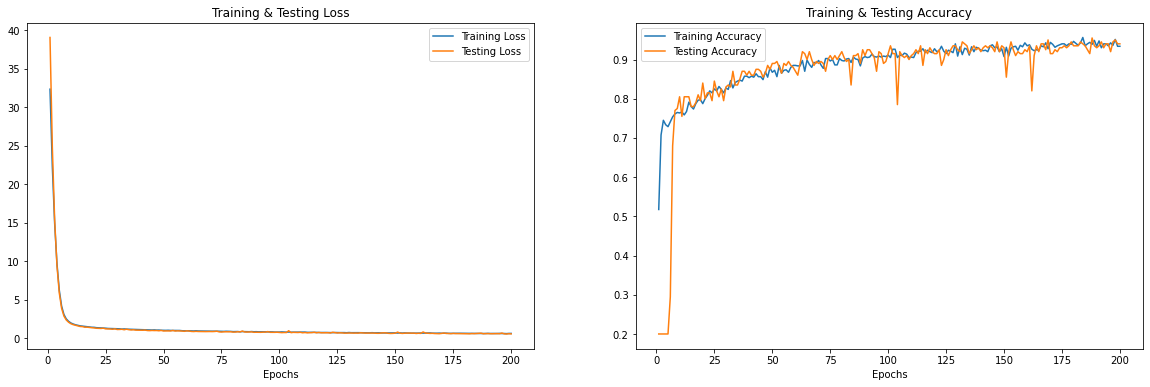

In [111]:
# You should be able to divide sample_amount by batch_size
train_features_1, train_labels_1 = extract_features(train_dir, 800, out_size = 1280, 
                                                    transfer = efficient_1, batch_size = 5, n_class = 5) 
test_features_1, test_labels_1 = extract_features(test_dir, 200, out_size = 1280, 
                                                    transfer = efficient_1, batch_size = 5, n_class = 5)
print("DONE")

eff_model_1 = Sequential()
eff_model_1.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
eff_model_1.add(layers.Dense(512, 
                       kernel_regularizer   = tf.keras.regularizers.l2(l = 0.05),
                       activity_regularizer = tf.keras.regularizers.l1(0.05),
                       bias_regularizer     = tf.keras.regularizers.l1(0.05),
                       activation='relu', 
                       input_dim=1280))

eff_model_1.add(layers.Dense(5, activation='softmax'))

eff_model_1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

eff_model_1.fit(train_features_1, train_labels_1,
                    epochs=200,
                    # batch_size=10,
                    verbose = 0,
                    validation_data=(test_features_1, test_labels_1))
print("Fitting Done")


loss_acc(eff_model_1)

              precision    recall  f1-score   support

          AS       0.93      1.00      0.96        40
          MR       0.94      0.85      0.89        40
          MS       0.97      0.88      0.92        40
         MVP       0.89      1.00      0.94        40
           N       0.97      0.97      0.97        40

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



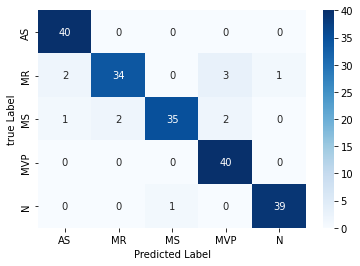

In [137]:
pred = eff_model_1.predict(test_features_1)
y_pred = np.argmax(pred, axis = 1)
y_true = np.argmax(test_labels_1, axis = 1)

labels = list(train_generator.class_indices.keys())

cf_matrix_test  = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred, target_names=labels))


g = sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')


g.xaxis.set_ticklabels(labels)
g.yaxis.set_ticklabels(labels)

g.set_xlabel('Predicted Label', fontsize=10)
g.set_ylabel('true Label', fontsize=10);
